<a href="https://colab.research.google.com/github/junho328/Deep_learning_with_Pytorch/blob/main/Pytorch_CH8_Unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 클러스터링
- K-Means

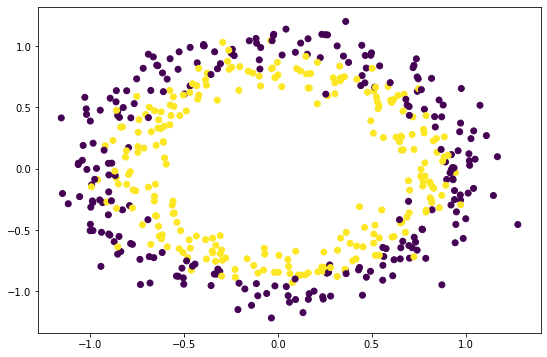

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
x,y = make_circles(n_samples=500,noise=0.1)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

In [ ]:
def l2distance(a,b):
  return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0)

In [ ]:
def kmeans(x,num_clusters=2,max_iteration=5):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  x = x.to(device)
  centroids = torch.rand(num_clusters, x.size(1)).to(device)
  for update in range(max_iteration):
    y_assign = []
    for m in range(x.size(0)):
      h = x[m].expand(num_clusters,-1)
      assign = l2distance(h,centroids)
      y_assign.append(assign.item())

    y_assign = np.array(y_assign)
    if update != max_iteration-1:
      for i in range(num_clusters):
        idx = np.where(y_assign==1)[0]
        centroids[i] = torch.mean(x[idx],dim=0)
    return y_assign, centroids

In [ ]:
y_pred, centroids = kmeans(x,2)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0],x[:,1],c=y_pred)
plt.plot(centroids[:,0],centroids[:,1],'*',markersize=30)
plt.show()

AttributeError: ignored

# Auto Encoder

In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset = torchvision.datasets.MNIST('./data/',download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Stack AutoEncoder

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,128),
        nn.ReLU(),
        nn.Linear(128,32),
        nn.ReLU(),
        nn.Linear(32,10),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(10,32),
        nn.ReLU(),
        nn.Linear(32,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid()
    )
  
  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
for epoch in range(10):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs.view(-1,28*28))
    outputs = outputs.view(-1,1,28,28)
    loss = criterion(inputs,outputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  cost = running_loss/len(trainloader)
  print('[%d]loss:%.3f'%(epoch+1,cost))

[1]loss:0.026
[2]loss:0.026
[3]loss:0.026
[4]loss:0.026
[5]loss:0.025
[6]loss:0.025
[7]loss:0.025
[8]loss:0.025
[9]loss:0.025
[10]loss:0.025


### Denoising AutoEncoder

In [ ]:
for epoch in range(10):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    dirty_inputs = inputs + torch.normal(0,0.5,size=inputs.size()).to(device)
    outputs = model(dirty_inputs.view(-1,28*28))
    outputs = outputs.view(-1,1,28,28)
    loss = criterion(inputs,outputs)
    
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  cost = running_loss / len(trainloader)
  print('[%d]loss: %3.f'%(epoch+1,cost))

[1]loss:   0
[2]loss:   0
[3]loss:   0
[4]loss:   0
[5]loss:   0
[6]loss:   0
[7]loss:   0
[8]loss:   0
[9]loss:   0
[10]loss:   0


### Convolutional AutoEncoder

*참고)
view와 reshape 차이
- view: contiguous 타입에만 사용 가능
- reshape: 제한 없음

-> 애매모호하면 reshape 사용 권장

In [ ]:
class Flatten(torch.nn.Module):
  def forward(self,x):
    batch_size = x.shape[0]
    return x.view(batch_size-1)

In [ ]:
class Deflatten(nn.Module):
  def __init__(self,k):
    super(Deflatten,self).__init__()
    self.k = k

  def forward(self,x):
    s = x.size()
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0],self.k,feature_size,feature_size)

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder,self).__init__()
    k = 16
    self.encoder = nn.Sequential(
        nn.Conv2d(1,k,3,stride=2),nn.ReLU(),
        nn.Conv2d(k,2*k,3,stride=2),nn.ReLU(),
        nn.Conv2d(2*k,4*k,3,stride=1),nn.ReLU(),
        Flatten(),nn.Linear(1024,10),nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(10,1024),nn.ReLU(),
        Deflatten(4*k),
        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1),nn.ReLU(),
        nn.ConvTranspose2d(2*k, k, 3, stride=2),nn.ReLU(),
        nn.ConvTranspose2d(k,1,3,stride=2,output_padding=1),nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [ ]:
for epoch in range(10):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(inputs,outputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  cost = runnig_loss/len(trainloader)
  print('[%d]loss: %.3f'%(epoch+1,cost))

RuntimeError: ignored

# GAN(Generative Adversarial Network)

###Vanilla GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
trainset = FashionMNIST(root='./data/',train=True,download=True,transform=transform)
trainloader = DataLoader(trainset,batch_size=100,shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 참고: super 사용법
super(B,self)__init__()

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.n_features = 128
    self.n_out = 784
    self.linear = nn.Sequential(
        nn.Linear(self.n_features,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024,self.n_out),
        nn.Tanh()
            )
    
  def forward(self,x):
    x = self.linear(x)
    x = x.view(-1,1,28,28)
    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_in = 784
    self.n_out = 1
    self.linear = nn.Sequential(
        nn.Linear(self.n_in, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256,self.n_out),
        nn.Sigmoid()            )
    
  def forward(self,x):
    x = x.view(-1,784)
    x = self.linear(x)
    return x

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
g_optim = optim.Adam(generator.parameters(),lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(),lr=2e-4)
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss()

In [ ]:
def noise(n,n_features=128):
  data = torch.randn(n,n_features)
  return data.to(device)

def label_ones(size):
  data = torch.ones(size,1)
  return data.to(device)

def label_zeros(size):
  data = torch.zeros(size,1)
  return data.to(device)

In [ ]:
def train_discriminator(optimizer,real_data, fake_data):
  n = real_data.size(0)
  optimizer.zero_grad()
  prediction_real = discriminator(real_data)
  d_loss = criterion(prediction_real, label_ones(n))
  prediction_fake = discriminator(fake_data)
  g_loss = criterion(prediction_fake, label_zeros(n))
  loss = d_loss + g_loss
  loss.backward()
  optimizer.step()
  return loss.item()

In [ ]:
def train_generator(optimizer,fake_data):
  n = fake_data.size(0)
  optimizer.zero_grad()
  prediction = discriminator(fake_data)
  loss = criterion(prediction,label_ones(n))
  loss.backward()
  optimizer.step()
  return loss.item()

In [ ]:
test_noise = noise(64)
l = len(trainloader)
for epoch in range(10):
  g_loss = 0.0
  d_loss = 0.0
  for data in trainloader:
    imgs,_ = data
    n = len(imgs)
    fake_data = generator(noise(n)).detach()
    real_data = imgs.to(device)
    d_loss += train_discriminator(d_optim,real_data,fake_data)
    fake_data = generator(noise(n))
    g_loss += train_generator(g_optim, fake_data)

  img = generator(test_noise).detach().cpu()
  img = make_grid(img)
  images.append(img)
  g_losses.append(g_loss/l)
  d_losses.append(d_loss/l)
  print('Epoch:{}:g_loss:{:.3f} d_loss:{:.3f}\r'.format(epoch,g_loss/l,d_loss/l))

Epoch:0:g_loss:2.783 d_loss:0.683
Epoch:1:g_loss:3.274 d_loss:0.595
Epoch:2:g_loss:3.052 d_loss:0.588
Epoch:3:g_loss:3.275 d_loss:0.465
Epoch:4:g_loss:2.860 d_loss:0.528
Epoch:5:g_loss:2.503 d_loss:0.620
Epoch:6:g_loss:2.365 d_loss:0.660
Epoch:7:g_loss:1.992 d_loss:0.778
Epoch:8:g_loss:2.036 d_loss:0.731
Epoch:9:g_loss:1.894 d_loss:0.771


In [ ]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items.gif',imgs)

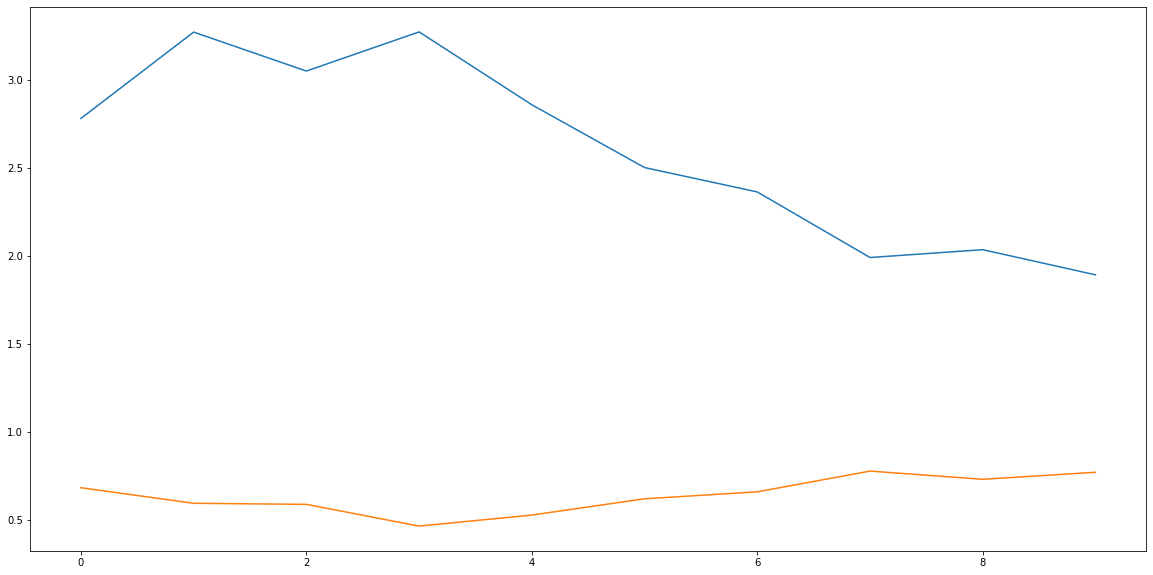

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)

###DCGAN (Deep Convolutional GAN)
- 일반적으로 MLP보다 CNN이 이미지 처리에 더 유용하다 (이유는 https://medium.com/analytics-vidhya/cnn-convolutional-neural-network-8d0a292b4498)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.n_features = 128
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=False), nn.ReLU(True),
        nn.ConvTranspose2d(256,128,3,2,bias=False), nn.ReLU(True),
        nn.ConvTranspose2d(128,64,3,2,bias=False),nn.ReLU(True),
        nn.ConvTranspose2d(64,1,2,2,1,bias=False),nn.Tanh()
    )
  def forward(self,x):
    x = x.view(-1,self.n_features,1,1)
    x = self.conv(x)
    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1,128,3,2,1,bias=False),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.5),
        nn.Conv2d(128,256,3,2,1,bias=False),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.5),
        nn.Conv2d(256,256,3,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Dropout(0.5),
        nn.Conv2d(256,1,3,2,bias=False),
        nn.Sigmoid()
    )

  def forward(self,x):
    x = self.conv(x)
    return x.view(-1,1)

#Image style transfer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [3]:
# 내용 손실 함수
class ContentLoss(nn.Module):
  def __init__(self,target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
  def forward(self,input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [4]:
# 스타일 손실 함수
def gram_matrix(input):
  a,b,c,d = input.size()
  features = input.view(a*b,c*d)
  G = torch.mm(features,features.t())
  return G.div(a*b*c*d)

In [5]:
class StyleLoss(nn.Module):
  def __init__(self,target_feature):
    super(StyleLoss,self).__init__()
    self.target = gram_matrix(target_feature).detach()
  
  def forward(self,input):
    G = gram_matrix(input)
    self.loss =F.mse_loss(G,self.target)
    return input

In [6]:
class Normalization(nn.Module):
  def __init__(self,mean,std):
    super(Normalization,self).__init__()
    self.mean = mean.view(-1,1,1)
    self.std = std.view(-1,1,1)

  def forward(self,img):
    return (img-self.mean)/self.std

In [7]:
# 모델 재정의
def get_style_model_and_losses(cnn,style_img,content_img):
  content_layers = ['conv_4']
  style_layers = ['conv_1','conv_2','conv_3','conv_4','conv_5']
  normalization_mean = torch.tensor([0.485,0.456,0.406]).to(device)
  normalization_std = torch.tensor([0.229,0.224,0.225]).to(device)
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)
  i = 0

  for layer in cnn.children():
    if isinstance(layer,nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'maxpool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer:{}'.format(layer.__class__.__name__))

    model.add_module(name,layer)
    if name in content_layers:
      target = model(content_img)
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)
    
    if name in style_layers:
      target_feature = model(style_img)
      style_loss = StyleLoss(target_feature)
      model.add_module('style_loss_{}'.format(i),style_loss)
      style_losses.append(style_loss)

  for i in range(len(model)-1,-1,-1):
    if isinstance(model[i],ContentLoss) or isinstance(model[i],StyleLoss):
      break
  
  model = model[:(i+1)]
  return model,style_losses,content_losses

  

In [8]:
# 결과 이미지 최적화
def run_style_transfer(cnn, content_img, style_img, num_steps = 300, style_weight = 100000, content_weight=1):
  input_img = content_img.clone().detach().requires_grad_(True)
  model, style_losses, content_losses = get_style_model_and_losses(cnn,style_img,content_img)
  optimizer = optim.LBFGS([input_img])
  iteration = [0]
  while iteration[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0,1)
      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      loss = style_weight * style_score + content_weight*content_score
      loss.backward()
      iteration[0] += 1
      if iteration[0]%50 == 0:
        print('Iteration {}:Style Loss:{:4f} Content Loss: {:4f}'.format(
            iteration[0],style_score.item(),content_score.item()
        ))
      return style_score + content_score
    optimizer.step(closure)
  return input_img.data.clamp_(0,1)


In [9]:
def image_loader(img_path):
  loader = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
  image = Image.open(img_path).convert('RGB')
  image = loader(image).unsqueeze(0)
  return image.to(device)
style_img = image_loader('/content/drive/MyDrive/imgA.jpg')
content_img = image_loader('/content/drive/MyDrive/imgB.jpg')

In [10]:
output = run_style_transfer(cnn,content_img,style_img)

Iteration 50:Style Loss:0.000135 Content Loss: 50.140450
Iteration 100:Style Loss:0.000042 Content Loss: 38.529461
Iteration 150:Style Loss:0.000025 Content Loss: 32.742332
Iteration 200:Style Loss:0.000021 Content Loss: 30.153028
Iteration 250:Style Loss:0.000019 Content Loss: 28.529024
Iteration 300:Style Loss:27.140366 Content Loss: 530.999878


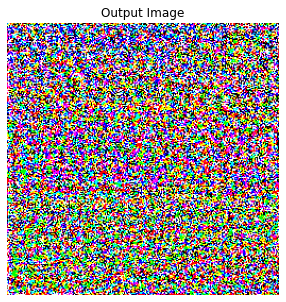

In [13]:
def imshow(image,title):
  unloader = transforms.ToPILImage()
  image = unloader(image.squeeze(0).cpu())
  plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.title(title)
  plt.axis('off')
  plt.show()
imshow(output,title='Output Image')

In [ ]:
# 왜 깨지는 걸까..

# Deep K-Means
- K-Means & AutoEncoder

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linear_sum_assignment as linear_assignment

In [ ]:
batch_size = 128
num_clusters = 10
latent_size = 10

In [ ]:
trainset = torchvision.datasets.MNIST('./data/',download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data/',download=True, train=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Flatten(torch.nn.Module):
  def forward(self,x):
    batch_size = x.shape[0]
    return x.view(batch_size,-1)
  
class Deflatten(nn.Module):
  def __init__(self,k):
    super(Deflatten,self).__init__()
    self.k = k
  def forward(self,x):
    s = x.size()
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0],self.k,feature_size,feature_size)

In [ ]:
class Kmeans(nn.Module):
  def __init__(self,num_clusters,latent_size):
    super(Kmeans,self).__init__()
    device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
    self.num_clusters = num_clusters
    self.centroids = nn.Parameter(torch.rand((self.num_clusters,latent_size)).to(device))

  def argminl2distance(self,a,b):
    return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0)

  def forward(self,x):
    y_assign = []
    for m in range(x.size(0)):
      h = x[m].expand(self.num_clusters,-1)
      assign = self.argminl2distance(h, self.centroids)
      y_assign.append(assign.item())
      
    return y_assign, self.centroids[y_assign]

In [ ]:
class Encoder(nn.Module):
  def __init__(self,latent_size):
    super(Encoder,self).__init__()

    k=16
    self.encoder = nn.Sequential(
        nn.Conv2d(1,k,3,stride=2),
        nn.ReLU(),
        nn.Conv2d(k,2*k,3,stride=2),
        nn.ReLU(),
        nn.Conv2d(2*k,4*k,3,stride=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(1024,latent_size),
        nn.ReLU()
    )
  
  def forward(self,x):
    return self.encoder(x)
    s = x.size()
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0],self.k,feature_size,feature_size)

class Decoder(nn.Module):
  def __init__(self, latent_size):
    super(Decoder, self).__init__()
    k=16
    
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 1024),
        nn.ReLU(),
        Deflatten(4*k),
        nn.ConvTranspose2d(4*k,2*k,3,stride=1),
        nn.ReLU(),
        nn.ConvTranspose2d(2*k,k,3, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(k,1,3,stride=2,output_padding=1),
        nn.Sigmoid()
    )

  def forward(self,x):
    return self.decoder(x)

In [ ]:
def cluster_acc(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  D = max(y_pred.max(),y_true.max())+1
  w = np.zeros((D,D),dtype=np.int64)
  for i in range(y_pred.size):
    w[y_pred[i],y_true[i]] += 1
  ind = linear_assignment(w.max()-w)

  return sum([w[i,j] for i,j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size

In [ ]:
def evaluation(testloader, encoder, kmeans, device):
  predictions = []
  actual = []

  with torch.no_grad():
    for images,labels in testloader:
      inputs = images.to(device)
      labels = labels.to(device)
      latent_var = encoder(inputs)
      y_pred,_ = kmeans(latent_var)

      predictions += y_pred
      actual += labels.cpu().tolist()

  return cluster_acc(actual,predictions)

In [ ]:
encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters, latent_size).to(device)
criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters())+list(kmeans.parameters()),lr=1e-3)

In [ ]:
T1 = 50
T2 = 200
lam = 1e-3
ls = 0.05

In [ ]:
for ep in range(10):
  if (ep>T1) and (ep<T2):
    alpha = lam*(ep-T1)/(T2-T1)
  elif ep >= T2:
    alpha = lam
  else:
    alpha = lam/(T2-T1)

  running_loss = 0.0
  for images,_ in trainloader:
    inputs = images.to(device)
    optimizer.zero_grad()
    latent_var = encoder(inputs)
    _,centroids = kmeans(latent_var.detach())
    outputs = decoder(latent_var)

    l_rec = criterion1(inputs,outputs)
    l_clt = criterion2(latent_var,centroids)

    loss = l_rec + alpha*l_clt
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  avg_loss = running_loss / len(trainloader)
  
  if ep % 9 == 0:
    testacc = evaluation(testloader, encoder, kmeans, device)
    print('[%d] Train loss: %.4f, Test Accuracy: %.3f'%(ep,avg_loss,testacc))

[0] Train loss: 0.0698, Test Accuracy: 0.114
